# Caso práctico: CNN con **CIFAR-10** (Keras)

Objetivo: entrenar y evaluar una **red neuronal convolucional** para clasificar imágenes del dataset **CIFAR-10**. Este dataset está disponible vía `tensorflow.keras.datasets` y se descarga automáticamente la primera vez que lo ejecutes en tu máquina.

Qué incluye:
1. Carga del dataset y EDA rápida.
2. Preprocesamiento y *data augmentation*.
3. Modelo CNN (bloques Conv-BN-ReLU + MaxPool + Dropout).
4. Entrenamiento con *callbacks* (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint).
5. Evaluación: accuracy, matriz de confusión, reporte de clasificación.


## 1) Dependencias

In [1]:
import os, math, itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.19.0


## 2) Cargar CIFAR-10 y EDA
CIFAR-10 tiene 60,000 imágenes color (32×32) en 10 clases.

In [2]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.squeeze()
y_test = y_test.squeeze()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


((50000, 32, 32, 3), (10000, 32, 32, 3), (50000,), (10000,))

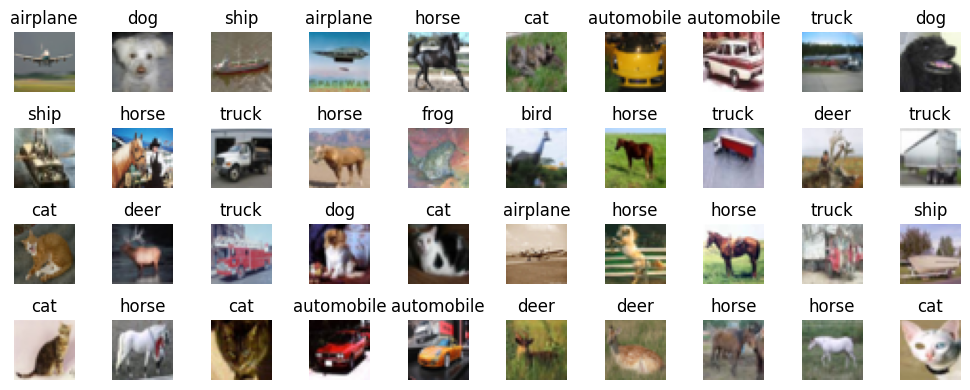

In [3]:
# Grid de ejemplos
cols, rows = 10, 4
plt.figure(figsize=(cols, rows))
for i in range(cols * rows):
    idx = np.random.randint(0, len(X_train))
    plt.subplot(rows, cols, i+1)
    plt.imshow(X_train[idx])
    plt.title(class_names[y_train[idx]])
    plt.axis('off')
plt.tight_layout()
plt.show()

## 3) Preprocesamiento y *split* validación
- Normalizamos a `[0,1]`.
- Separamos validación desde el *train*.
- Creamos `tf.data` pipelines con *data augmentation*.

In [4]:
X_train = (X_train/255.0).astype('float32')
X_test  = (X_test /255.0).astype('float32')

# Split validación
val_ratio = 0.1
n_val = int(len(X_train)*val_ratio)
X_val, y_val = X_train[:n_val], y_train[:n_val]
X_train_sub, y_train_sub = X_train[n_val:], y_train[n_val:]
X_train_sub.shape, X_val.shape

((45000, 32, 32, 3), (5000, 32, 32, 3))

In [5]:
batch_size = 128

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

def make_ds(X, y, training=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(8192)
        ds = ds.map(lambda x, t: (data_augmentation(x, training=True), t),
                    num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

ds_train = make_ds(X_train_sub, y_train_sub, training=True)
ds_val   = make_ds(X_val, y_val, training=False)
ds_test  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

## 4) Modelo CNN base
Bloques Conv-BN-ReLU + MaxPool. Cerramos con GlobalAveragePooling y una capa densa.

In [6]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    return x

def build_model(input_shape=(32,32,3), num_classes=10):
    inputs = keras.Input(shape=input_shape)
    x = conv_block(inputs, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 289,642 (1.10 MB)

 Trainable params: 288,746 (1.10 MB)

 Non-trainable params: 896 (3.50 KB)

## 5) Entrenamiento con *callbacks*

In [8]:
ckpt_path = 'best_cifar10_cnn.keras'
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor='val_accuracy', mode='max'),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

history = model.fit(
    ds_train,
    epochs=3,
    validation_data=ds_val,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - accuracy: 0.6862 - loss: 0.8925 - val_accuracy: 0.6008 - val_loss: 1.2613 - learning_rate: 0.0010
Epoch 2/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - accuracy: 0.7075 - loss: 0.8338 - val_accuracy: 0.6962 - val_loss: 0.8987 - learning_rate: 0.0010
Epoch 3/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - accuracy: 0.7214 - loss: 0.8028 - val_accuracy: 0.7318 - val_loss: 0.7745 - learning_rate: 0.0010


## 6) Curvas de aprendizaje

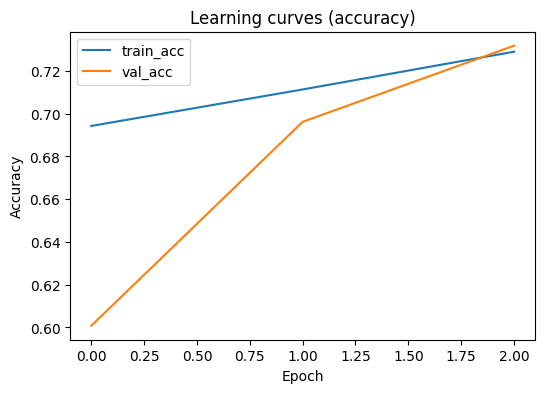

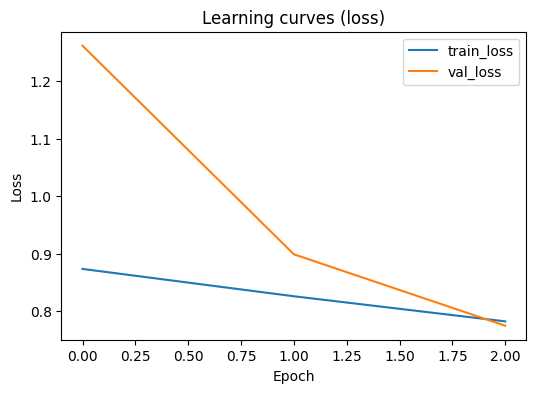

In [9]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning curves (accuracy)')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning curves (loss)')
plt.show()

## 7) Evaluación en test

In [10]:
test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

y_pred_prob = model.predict(ds_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))

Test accuracy: 0.7252
              precision    recall  f1-score   support

    airplane       0.74      0.77      0.75      1000
  automobile       0.87      0.90      0.89      1000
        bird       0.86      0.40      0.55      1000
         cat       0.52      0.66      0.58      1000
        deer       0.71      0.72      0.72      1000
         dog       0.83      0.43      0.57      1000
        frog       0.62      0.89      0.73      1000
       horse       0.83      0.76      0.79      1000
        ship       0.91      0.79      0.84      1000
       truck       0.66      0.93      0.77      1000

    accuracy                           0.73     10000
   macro avg       0.75      0.73      0.72     10000
weighted avg       0.75      0.73      0.72     10000



## 8) Matriz de confusión

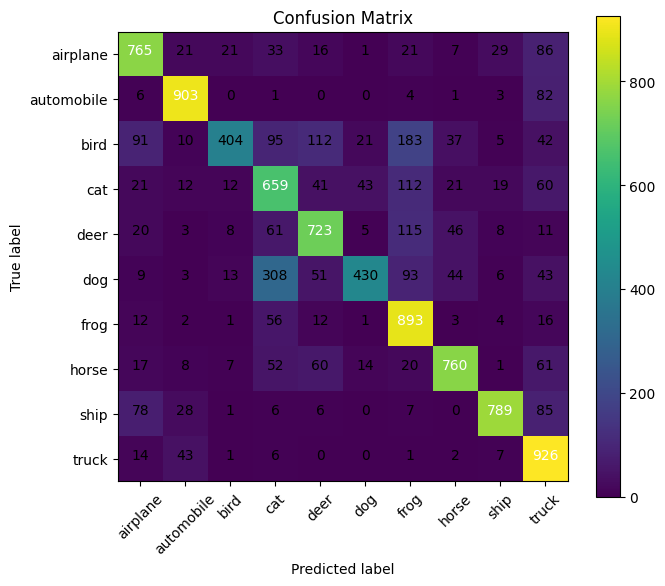

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## 9) Errores más frecuentes y ejemplos mal clasificados

Parejas (real->pred) más frecuentes:


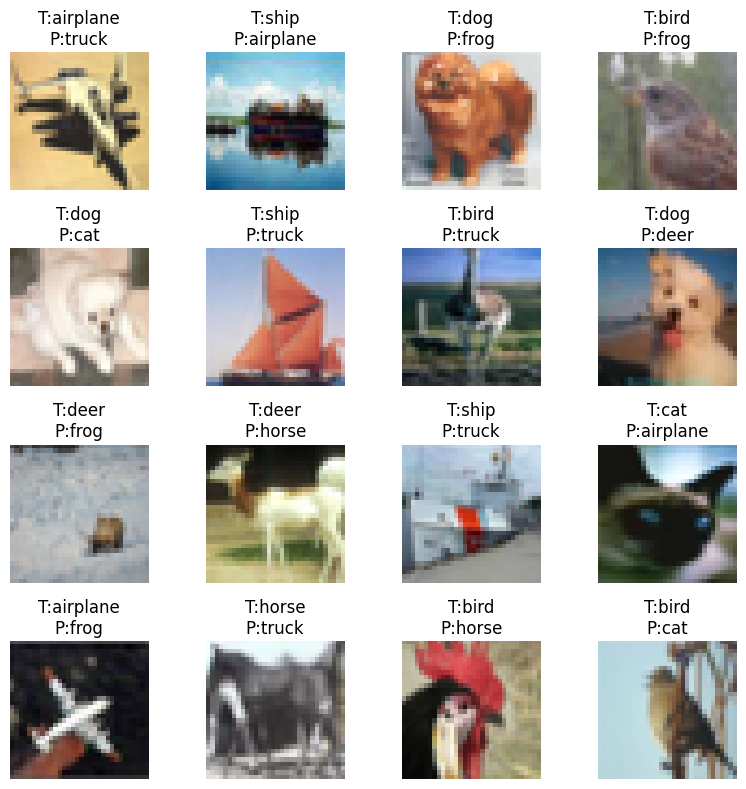

In [12]:
# Conteo por par (real, predicho)
pairs = list(zip(y_test, y_pred))
from collections import Counter
counter = Counter(pairs)
print('Parejas (real->pred) más frecuentes:')
for (t,p), c in counter.most_common(10):
    if t != p:
        print(f"{class_names[t]} -> {class_names[p]}: {c}")

# Muestra de mal clasificados
wrong_idx = np.where(y_test != y_pred)[0]
np.random.shuffle(wrong_idx)
n_show = 16
plt.figure(figsize=(8,8))
for i, idx in enumerate(wrong_idx[:n_show]):
    plt.subplot(4,4,i+1)
    plt.imshow(X_test[idx])
    plt.title(f"T:{class_names[y_test[idx]]}\nP:{class_names[y_pred[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()